# [0] Importing Libraries

In [1]:
!pip install colorama

In [2]:
import os
import pandas as pd
import numpy as np
import random
import torch
from tqdm.auto import tqdm
from colorama import Fore, Style
import joblib

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

device = "cuda" if torch.cuda.is_available() else 'cpu'

# [1] Loading [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) Dataset

Only need to run once

In [3]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz # downloading
!tar xzf aclImdb_v1.tar.gz  # extracting

--2024-10-31 03:41:16--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  5.79MB/s    in 11s     

2024-10-31 03:41:28 (7.25 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



Creating Pandas dataframe

In [4]:
def fetch_reviews(path):
  data = []
  files = [f for f in os.listdir(path)]
  for file in files:
    with open(path+file, "r", encoding='utf8') as f:
      data.append(f.read())

  return data

In [5]:
df_train_pos = pd.DataFrame({'review': fetch_reviews('aclImdb/train/pos/'), 'label': 1})
df_train_neg = pd.DataFrame({'review': fetch_reviews('aclImdb/train/neg/'), 'label': 0})

df_test_pos = pd.DataFrame({'review': fetch_reviews('aclImdb/test/pos/'), 'label': 1})
df_test_neg = pd.DataFrame({'review': fetch_reviews('aclImdb/test/neg/'), 'label': 0})

df = pd.concat([df_train_pos, df_train_neg, df_test_pos, df_test_neg], ignore_index=True)
df

,review,label
0,Finally a movie where the audience is kept gue...,1
1,This is a great film. From reading other revie...,1
2,I saw this movie with my family and it was gre...,1
3,What can you possibly say about a show of this...,1
4,I had the privilege to see this movie at the I...,1
...,...,...
49995,That's the only word I can think of to describ...,0
49996,The most positive points in this film were the...,0
49997,"Once again, I've been duped by seemingly intel...",0
49998,Unfortunately I think this is one of those fil...,0


In [6]:
df['review'].isnull().sum()

0

In [7]:
print("Total Number of positive reviews in data: ", df[df['label']==1].shape[0])
print("Total Number of negative reviews in data: ", df[df['label']==0].shape[0])

Total Number of positive reviews in data:  25000
Total Number of negative reviews in data:  25000


# [2] Cleaning Movie Reviews Text

In [8]:
%%capture
import re
import nltk
import nltk
nltk.download('punkt')
nltk.download('punkt_tab') # At first you have to download these nltk packages.
nltk.download('stopwords')
nltk.download('wordnet')
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
!unzip -o /usr/share/nltk_data/corpora/punkt_tab.zip -d /usr/share/nltk_data/corpora/
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english') # defining stop_words

for word in ["not", "no", "never", "neither", "none"]:
    if word in stop_words:
        stop_words.remove(word)

lemmatizer = WordNetLemmatizer()

In [9]:
def data_preprocessing(review):
    # Remove HTML tags
    review = re.sub(r'<.*?>', '', review)

    # Remove URLs, emails, and mentions
    review = re.sub(r'http\S+|www\S+|https\S+', '', review, flags=re.MULTILINE)
    review = re.sub(r'\S+@\S+', '', review)
    review = re.sub(r'@\w+', '', review)

    # Keep only alphanumeric characters and spaces
    review = re.sub(r'[^A-Za-z0-9\s]', ' ', review)

    # Convert to lowercase
    review = review.lower()

    # Tokenization
    tokens = word_tokenize(review)

    # Stopwords removal
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a single string
    processed_review = ' '.join(tokens)

    return processed_review

In [10]:
df['preprocessed_review'] = df['review'].map(data_preprocessing)

In [11]:
import re

# Combined mapping of Gen Z lingo, abbreviations, and short forms with their full forms
slang_and_short_forms = {
    # Gen Z lingo
    "brb": "be right back",
    "idk": "I don't know",
    "imo": "in my opinion",
    "tbh": "to be honest",
    "smh": "shaking my head",
    "lit": "amazing",
    "sus": "suspicious",
    "bff": "best friend forever",
    "fomo": "fear of missing out",
    "yolo": "you only live once",
    "goat": "greatest of all time",
    "rn": "right now",
    "lmk": "let me know",
    "ikr": "I know, right",
    "hmu": "hit me up",
    "slay": "succeed",
    "vibes": "feelings",
    "tea": "gossip",
    "bae": "before anyone else",
    "stan": "support passionately",
    "irl": "in real life",
    "pog": "awesome",
    "simp": "obsessive admirer",
    "ngl": "not gonna lie",
    "fr": "for real",
    "no cap": "no lie",
    "lit af": "extremely good",
    "gucci": "good",
    "finna": "fixing to",
    "salty": "bitter",
    "lowkey": "kind of",
    "highkey": "definitely",
    "bop": "good song",
    "pressed": "upset",
    "savage": "bold",
    "flex": "show off",
    "thirsty": "desperate",
    "woke": "aware",

    # Common abbreviations and short forms
    "omw": "on my way",
    "nvm": "never mind",
    "gtg": "got to go",
    "ttyl": "talk to you later",
    "asap": "as soon as possible",
    "afaik": "as far as I know",
    "btw": "by the way",
    "cya": "see you",
    "dm": "direct message",
    "fyi": "for your information",
    "gg": "good game",
    "gr8": "great",
    "jk": "just kidding",
    "np": "no problem",
    "omg": "oh my god",
    "pls": "please",
    "rofl": "rolling on the floor laughing",
    "thx": "thanks",
    "ttfn": "ta ta for now",
    "wfh": "work from home",
    "wtf": "what the heck",
    "idc": "I don't care",
    "omfg": "oh my freaking god",
    "ftw": "for the win",
    "b4": "before",
    "b/c": "because",
    "l8r": "later",
    "tbf": "to be fair",
    "afk": "away from keyboard",
    "bday": "birthday",
    "bbl": "be back later",
    "bf": "boyfriend",
    "gf": "girlfriend",
    "grwm": "get ready with me",
    "bts": "behind the scenes",
    "idgaf": "I don't give a freak",
    "bruh": "brother",
    "srsly": "seriously",
    "xoxo": "hugs and kisses",
    "lmao": "laughing my ass off",
    "tysm": "thank you so much",
    "ily": "I love you",
    "imho": "in my humble opinion",
    "atm": "at the moment",
    "tbqh": "to be quite honest",
    "wtg": "way to go"
}

In [12]:
def expand_slang_and_short_forms(text):
    for slang, full_form in slang_and_short_forms.items():
        text = re.sub(r'\b' + slang + r'\b', full_form, text)
    return text

In [13]:
# Apply it to your dataset
df['preprocessed_review'] = df['preprocessed_review'].map(expand_slang_and_short_forms)

In [14]:
df.to_parquet('df_preprocessed_review.parquet')
df = pd.read_parquet('df_preprocessed_review.parquet')
df

,review,label,preprocessed_review
0,Finally a movie where the audience is kept gue...,1,finally movie audience kept guessing end happe...
1,This is a great film. From reading other revie...,1,great film reading review see not one shed tea...
2,I saw this movie with my family and it was gre...,1,saw movie family great film documentary offer ...
3,What can you possibly say about a show of this...,1,possibly say show magnitude soprano literally ...
4,I had the privilege to see this movie at the I...,1,privilege see movie intenational film festival...
...,...,...,...
49995,That's the only word I can think of to describ...,0,word think describe movie not waste waste time...
49996,The most positive points in this film were the...,0,positive point film credit text style moment i...
49997,"Once again, I've been duped by seemingly intel...",0,duped seemingly intelligent review making seem...
49998,Unfortunately I think this is one of those fil...,0,unfortunately think one film took studio said ...


# [3] Splitting into Train and Validation sets

In [15]:
from sklearn.model_selection import train_test_split

data = df.drop(['label'], axis=1, inplace=False)
targets = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, stratify=targets)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (40000, 2) (40000,)
Test data: (10000, 2) (10000,)


In [16]:
X_train

,review,preprocessed_review
39399,"""Go Fish"" garnered Rose Troche rightly or wron...",go fish garnered rose troche rightly wrongly r...
19627,It's interesting to see what shape Pierce Bros...,interesting see shape pierce brosnan career bo...
34300,"Skenbart takes place in the 1940s, right after...",skenbart take place 1940s right second world w...
15058,Michael Caine has always claimed that Ashanti ...,michael caine always claimed ashanti film pure...
1486,The 1960's TV series Bewitched owes it's idea ...,1960 tv series bewitched owes idea movie movie...
...,...,...
40040,The other lowest-rating reviewers have summed ...,lowest rating reviewer summed sewage perfectly...
17194,"This is, without a doubt, the single worst mov...",without doubt single worst movie ever created ...
22471,Arthur Askey's great skill as a comic was in t...,arthur askey great skill comic way communicate...
39427,Tedium as only the French can do it. I checked...,tedium french checked watch first time 7 minut...


# [4] Vectorizer Movie Reviews

In [17]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

max_features = 5000 # or None

vectorizer = TfidfVectorizer(max_features=max_features).fit(X_train.preprocessed_review)
vectorizer

CPU times: user 3.68 s, sys: 81 ms, total: 3.76 s
Wall time: 3.78 s


TfidfVectorizer(max_features=5000)

Saving vectorizer for inference

In [18]:
os.makedirs('checkpoints', exist_ok=True)
joblib.dump(vectorizer, "checkpoints/vectorizer.joblib")

['checkpoints/vectorizer.joblib']

In [19]:
print("Vocabulary size:", len(vectorizer.vocabulary_))

Vocabulary size: 5000


In [20]:
vectorizer.vocabulary_

{'go': 1959,
 'fish': 1770,
 'rose': 3795,
 'reputation': 3688,
 'film': 1749,
 'maker': 2748,
 'much': 2955,
 'promise': 3467,
 'hard': 2074,
 'understand': 4677,
 'could': 1046,
 'turn': 4642,
 'movie': 2950,
 'made': 2730,
 'stereotype': 4246,
 'one': 3135,
 'associate': 336,
 'inferior': 2321,
 'sitcom': 4065,
 'entire': 1533,
 'ring': 3747,
 'hollow': 2170,
 'whole': 4894,
 'way': 4856,
 'supposed': 4369,
 'look': 2684,
 'ninety': 3047,
 'human': 2224,
 'sexuality': 3971,
 'well': 4875,
 'not': 3073,
 'learned': 2596,
 'actually': 122,
 'know': 2534,
 'men': 2830,
 'sexually': 3972,
 'attracted': 358,
 'woman': 4935,
 'even': 1568,
 'sex': 3969,
 'seldom': 3924,
 'revelation': 3723,
 'portrayed': 3368,
 'screen': 3890,
 'little': 2663,
 'wit': 4926,
 'style': 4312,
 'pathetic': 3231,
 'interesting': 2367,
 'see': 3913,
 'shape': 3982,
 'brosnan': 610,
 'career': 695,
 'bond': 543,
 'arrived': 311,
 'scene': 3874,
 'tense': 4466,
 'thriller': 4513,
 'play': 3320,
 'gentle': 1926,
 

In [21]:
X_train_vec = vectorizer.transform(X_train.preprocessed_review)
X_test_vec = vectorizer.transform(X_test.preprocessed_review)

print('X_train_vec shape: ', X_train_vec.shape)
print('X_test_vec shape: ', X_test_vec.shape)

X_train_vec shape:  (40000, 5000)
X_test_vec shape:  (10000, 5000)


# [5] Creating Tensor Dataset and Dataloader

In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_printoptions(precision=16)

X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [23]:
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()
INPUT_SIZE = len(vectorizer.vocabulary_)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              pin_memory=True,
                              num_workers=NUM_WORKERS,
                              persistent_workers=True,
                              drop_last=True,
                              shuffle=True)

val_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE*2,
                             pin_memory=True,
                             num_workers=NUM_WORKERS,
                             persistent_workers=True,
                             drop_last=False,
                             shuffle=False)

In [24]:
inputs, targets = next(iter(train_dataloader))
inputs.shape, targets.shape

(torch.Size([128, 5000]), torch.Size([128]))

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# [6] *Recurrent Neural Network* (RNN)

In [25]:
from torch import nn

class ImdbRNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_size = INPUT_SIZE
        self.rnn_hidden_size = 130
        self.rnn_layers = 3
        self.fc_size = [64, 32, 16]
        self.op_size = 1


        # RNN Layer
        # [BATCH_SIZE, max_features] --> ([BATCH_SIZE, rnn_hidden_size], [rnn_layers, rnn_hidden_size])
        # [128, 5000] --> ([128, 130], (1, 130))
        self.rnn = nn.RNN(input_size=self.input_size,
                          hidden_size=self.rnn_hidden_size,
                          num_layers=self.rnn_layers,
                          bias=True,
                          batch_first=True,
                          dropout=0.4,
                          bidirectional=False
                         )


        # Classifier Head
        # [BATCH_SIZE, rnn_hidden_size] --> [BATCH_SIZE, op_size]
        # [128, 130] --> [129, 1]
        self.layer_stack = nn.Sequential(

            # [BATCH_SIZE, rnn_hidden_size] --> [BATCH_SIZE, rnn_hidden_size]
            # [128, 130] --> [128, 130]
            nn.LayerNorm(normalized_shape=self.rnn_hidden_size),

            # [BATCH_SIZE, rnn_hidden_size] --> [BATCH_SIZE, fc_size[0]]
            # [128, 130] --> [128, 64]
            nn.Linear(in_features=self.rnn_hidden_size, out_features=self.fc_size[0], bias=True),
            nn.BatchNorm1d(self.fc_size[0]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[0]] --> [BATCH_SIZE, fc_size[1]]
            # [128, 64] --> [128, 32]
            nn.Linear(in_features=self.fc_size[0], out_features=self.fc_size[1], bias=True),
            nn.BatchNorm1d(self.fc_size[1]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[1]] --> [BATCH_SIZE, fc_size[2]]
            # [128, 32] --> [128, 16]
            nn.Linear(in_features=self.fc_size[1], out_features=self.fc_size[2], bias=True),
            nn.BatchNorm1d(self.fc_size[2]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[2]] --> [BATCH_SIZE, op_size]
            # [128, 16] --> [128, 1]
            nn.Linear(in_features=self.fc_size[2], out_features=self.op_size, bias=True)
        )

        self.fc = nn.Linear(in_features=self.rnn_hidden_size, out_features=self.op_size, bias=True)


    def forward(self, x):
        rnn_op, _ = self.rnn(x)
        return self.layer_stack(rnn_op)
        # return self.fc(rnn_op)

In [26]:
# inputs, targets = inputs.to(device), targets.to(device)
# logits = ImdbRNN().to(device)(inputs)

# [7] Training *RNN*

In [27]:
epochs = 10
loss_function = torch.nn.BCEWithLogitsLoss().to(device)
model = ImdbRNN().to(device)
# model = torch.nn.DataParallel(model, device_ids=[0, 1]).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.001)

Epoch:  1 | Loss: (0.6360, 0.3470) | Acc: (61.1729, 86.7480)% | F1: (63.3502, 86.7186)% |
Epoch:  2 | Loss: (0.3456, 0.2929) | Acc: (86.6486, 87.6367)% | F1: (86.7683, 88.2193)% |
Epoch:  3 | Loss: (0.2843, 0.2888) | Acc: (89.1627, 87.8027)% | F1: (89.2028, 88.1255)% |
Epoch:  4 | Loss: (0.2685, 0.2919) | Acc: (89.9038, 87.7637)% | F1: (89.9196, 87.6245)% |
Epoch:  5 | Loss: (0.2576, 0.3010) | Acc: (90.3370, 87.8320)% | F1: (90.3420, 88.0053)% |
Epoch:  6 | Loss: (0.2514, 0.2984) | Acc: (90.8403, 87.6270)% | F1: (90.8140, 88.1511)% |
Epoch:  7 | Loss: (0.2410, 0.3081) | Acc: (90.8078, 87.9492)% | F1: (90.8027, 87.9628)% |
Epoch:  8 | Loss: (0.2431, 0.2933) | Acc: (90.9130, 88.2129)% | F1: (90.9404, 88.4156)% |
Epoch:  9 | Loss: (0.2379, 0.2992) | Acc: (91.2210, 87.8320)% | F1: (91.2480, 87.5839)% |
Epoch:  10 | Loss: (0.2330, 0.3098) | Acc: (91.3987, 87.0898)% | F1: (91.3506, 87.7442)% |
Model checkpoint saved at epoch 8


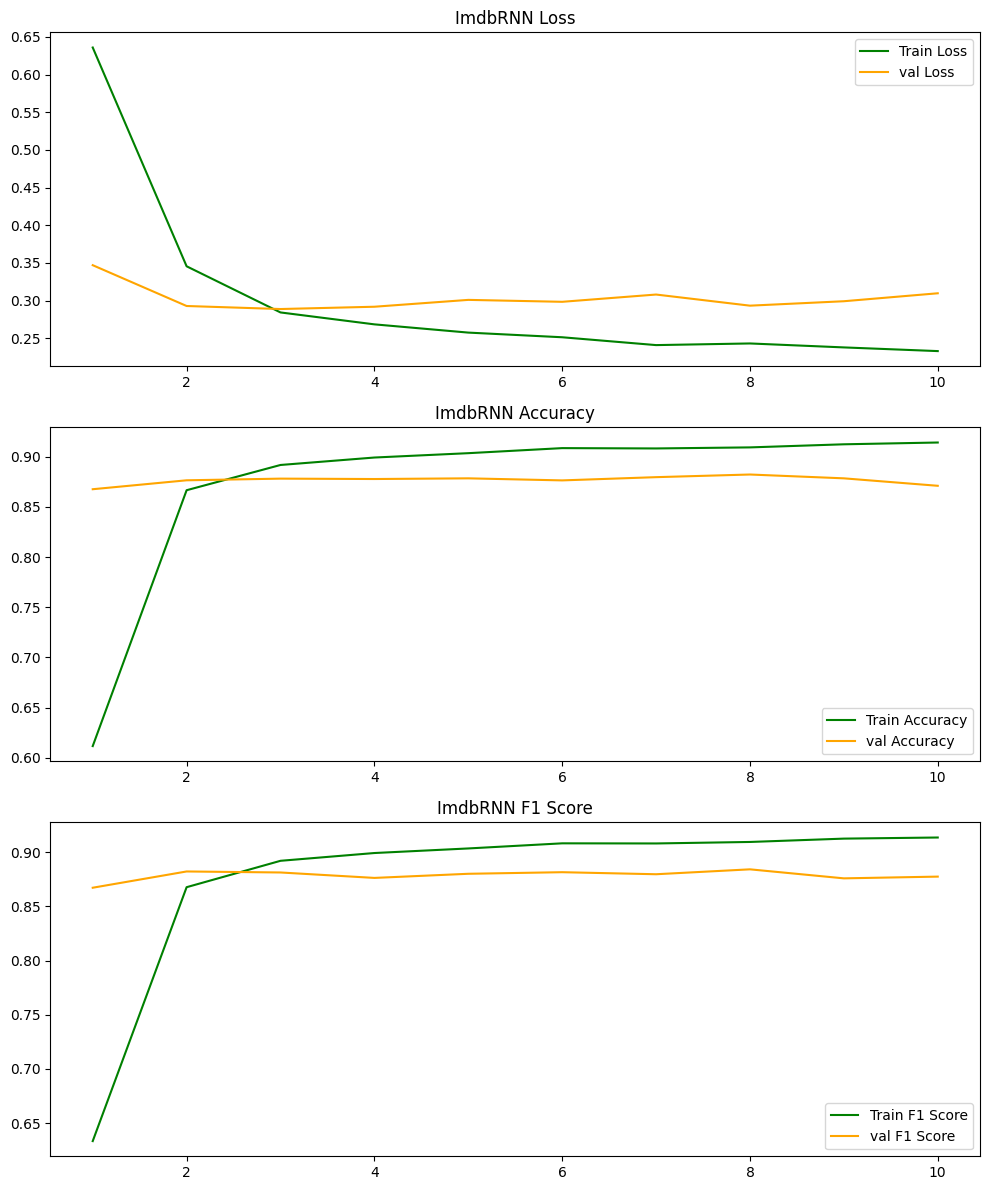

In [28]:
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


MODEL_NAME = "ImdbRNN"
best_cum_val_acc = 0
best_weights = None
best_epoch = np.inf

results = {"train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": [],
            "train_f1": [],
            "val_f1": []
            }


for epoch in range(epochs):
    cum_train_loss, cum_train_acc, cum_train_f1 = 0, 0, 0
    model.train()

    for batch, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        y_logits = model(inputs).squeeze()

        train_loss = loss_function(y_logits, targets)

        optimizer.zero_grad()
        train_loss.backward()
        cum_train_loss += train_loss.item()
        optimizer.step()


        y_probs = y_logits.sigmoid()
        y_preds = (y_probs >= 0.5).float()

        cum_train_acc += accuracy_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())
        cum_train_f1 += f1_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())

    cum_train_loss /= len(train_dataloader)
    cum_train_acc /= len(train_dataloader)
    cum_train_f1 /= len(train_dataloader)

    # validation loop
    cum_val_loss, cum_val_acc, cum_val_f1 = 0, 0, 0
    model.eval()

    with torch.inference_mode():
        for batch, (inputs, targets) in enumerate(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            y_logits = model(inputs).squeeze()

            test_loss = loss_function(y_logits, targets)
            cum_val_loss += test_loss.item()

            y_probs = y_logits.sigmoid()
            y_preds = (y_probs >= 0.5).float()

            cum_val_acc += accuracy_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())
            cum_val_f1 += f1_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())

        cum_val_loss /= len(val_dataloader)
        cum_val_acc /= len(val_dataloader)
        cum_val_f1 /= len(val_dataloader)


    if cum_val_acc > best_cum_val_acc:
        best_cum_val_acc = cum_val_acc
        best_weights = copy.deepcopy(model.state_dict())
        best_epoch = epoch+1

    epoch_display = f" {epoch+1}" if epoch < 10 else epoch
    print(f"Epoch: {Fore.YELLOW}{epoch_display}{Style.RESET_ALL} | "
            f"Loss: ({Fore.YELLOW}{cum_train_loss:.4f}, {cum_val_loss:.4f}{Style.RESET_ALL}) | "
            f"Acc: ({Fore.YELLOW}{100*cum_train_acc:.4f}, {100*cum_val_acc:.4f}{Style.RESET_ALL})% | "
            f"F1: ({Fore.YELLOW}{100*cum_train_f1:.4f}, {100*cum_val_f1:.4f}{Style.RESET_ALL})% |")


    results["train_loss"].append(cum_train_loss)
    results["val_loss"].append(cum_val_loss)
    results["train_acc"].append(cum_train_acc)
    results["val_acc"].append(cum_val_acc)
    results["train_f1"].append(cum_train_f1)
    results["val_f1"].append(cum_val_f1)


### Saving Best Model weights
os.makedirs('checkpoints', exist_ok=True)
torch.save(best_weights, f"checkpoints/{MODEL_NAME}_checkpoint.pth.tar")
print(f'Model checkpoint saved at epoch {best_epoch}')

plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.plot(np.arange(1,epochs+1), results["train_loss"], label='Train Loss', color='green')
plt.plot(np.arange(1,epochs+1), results["val_loss"], label='val Loss', color='orange')
plt.title(f'{MODEL_NAME} Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.arange(1,epochs+1), results["train_acc"], label='Train Accuracy', color='green')
plt.plot(np.arange(1,epochs+1), results["val_acc"], label='val Accuracy', color='orange')
plt.title(f'{MODEL_NAME} Accuracy')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.arange(1,epochs+1), results["train_f1"], label='Train F1 Score', color='green')
plt.plot(np.arange(1,epochs+1), results["val_f1"], label='val F1 Score', color='orange')
plt.title(f'{MODEL_NAME} F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

/////////////////////////////////////////////////////////////////////////////////////////////////////////

# [8] *Long Short-Term Memory* (LSTM) Recurrent Neural Network

In [29]:
from torch import nn

class ImdbLSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_size = INPUT_SIZE
        self.lstm_hidden_size = 130
        self.lstm_layers = 3
        self.fc_size = [64, 32, 16]
        self.op_size = 1


        # LSTM Layer
        # [BATCH_SIZE, max_features] --> ([BATCH_SIZE, lstm_hidden_size], [lstm_layers, lstm_hidden_size])
        # [128, 5000] --> ([128, 130], (1, 130))
        self.lstm = nn.LSTM(input_size=self.input_size,
                           hidden_size=self.lstm_hidden_size,
                           num_layers=self.lstm_layers,
                           bias=True,
                           batch_first=True,
                           dropout=0.4,
                           bidirectional=False
                          )



        # Classifier Head
        # [BATCH_SIZE, lstm_hidden_size] --> [BATCH_SIZE, op_size]
        # [128, 130] --> [129, 1]
        self.layer_stack = nn.Sequential(

            # [BATCH_SIZE, lstm_hidden_size] --> [BATCH_SIZE, lstm_hidden_size]
            # [128, 130] --> [128, 130]
            nn.LayerNorm(normalized_shape=self.lstm_hidden_size),

            # [BATCH_SIZE, lstm_hidden_size] --> [BATCH_SIZE, fc_size[0]]
            # [128, 130] --> [128, 64]
            nn.Linear(in_features=self.lstm_hidden_size, out_features=self.fc_size[0], bias=True),
            nn.BatchNorm1d(self.fc_size[0]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[0]] --> [BATCH_SIZE, fc_size[1]]
            # [128, 64] --> [128, 32]
            nn.Linear(in_features=self.fc_size[0], out_features=self.fc_size[1], bias=True),
            nn.BatchNorm1d(self.fc_size[1]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[1]] --> [BATCH_SIZE, fc_size[2]]
            # [128, 32] --> [128, 16]
            nn.Linear(in_features=self.fc_size[1], out_features=self.fc_size[2], bias=True),
            nn.BatchNorm1d(self.fc_size[2]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[2]] --> [BATCH_SIZE, op_size]
            # [128, 16] --> [128, 1]
            nn.Linear(in_features=self.fc_size[2], out_features=self.op_size, bias=True)
        )

        self.fc = nn.Linear(in_features=self.lstm_hidden_size, out_features=self.op_size, bias=True)


    def forward(self, x):
        lstm_op, _ = self.lstm(x)
        return self.layer_stack(lstm_op)
        # return self.fc(lstm_op)

# [9] Training *LSTM*

In [30]:
epochs = 10
loss_function = torch.nn.BCEWithLogitsLoss().to(device)
model = ImdbLSTM().to(device)
# model = torch.nn.DataParallel(model, device_ids=[0, 1]).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.001)

Epoch:  1 | Loss: (0.7025, 0.6941) | Acc: (50.0676, 50.3516)% | F1: (45.1570, 66.6059)% |
Epoch:  2 | Loss: (0.6947, 0.6928) | Acc: (50.0000, 50.0000)% | F1: (54.5802, 66.6077)% |
Epoch:  3 | Loss: (0.6235, 0.3283) | Acc: (62.9482, 86.9824)% | F1: (66.6106, 86.8096)% |
Epoch:  4 | Loss: (0.3227, 0.2787) | Acc: (87.6903, 87.9688)% | F1: (87.7026, 87.7379)% |
Epoch:  5 | Loss: (0.2671, 0.2787) | Acc: (90.1067, 88.2129)% | F1: (90.1178, 88.4002)% |
Epoch:  6 | Loss: (0.2472, 0.2826) | Acc: (90.7026, 88.4082)% | F1: (90.7033, 88.4156)% |
Epoch:  7 | Loss: (0.2339, 0.2947) | Acc: (91.5865, 88.1738)% | F1: (91.6111, 88.1010)% |
Epoch:  8 | Loss: (0.2287, 0.2977) | Acc: (91.7092, 87.8906)% | F1: (91.6574, 87.6498)% |
Epoch:  9 | Loss: (0.2182, 0.3035) | Acc: (92.1775, 88.1543)% | F1: (92.1676, 88.1985)% |
Epoch:  10 | Loss: (0.2104, 0.3123) | Acc: (92.5055, 87.7832)% | F1: (92.5147, 88.0165)% |
Model checkpoint saved at epoch 6


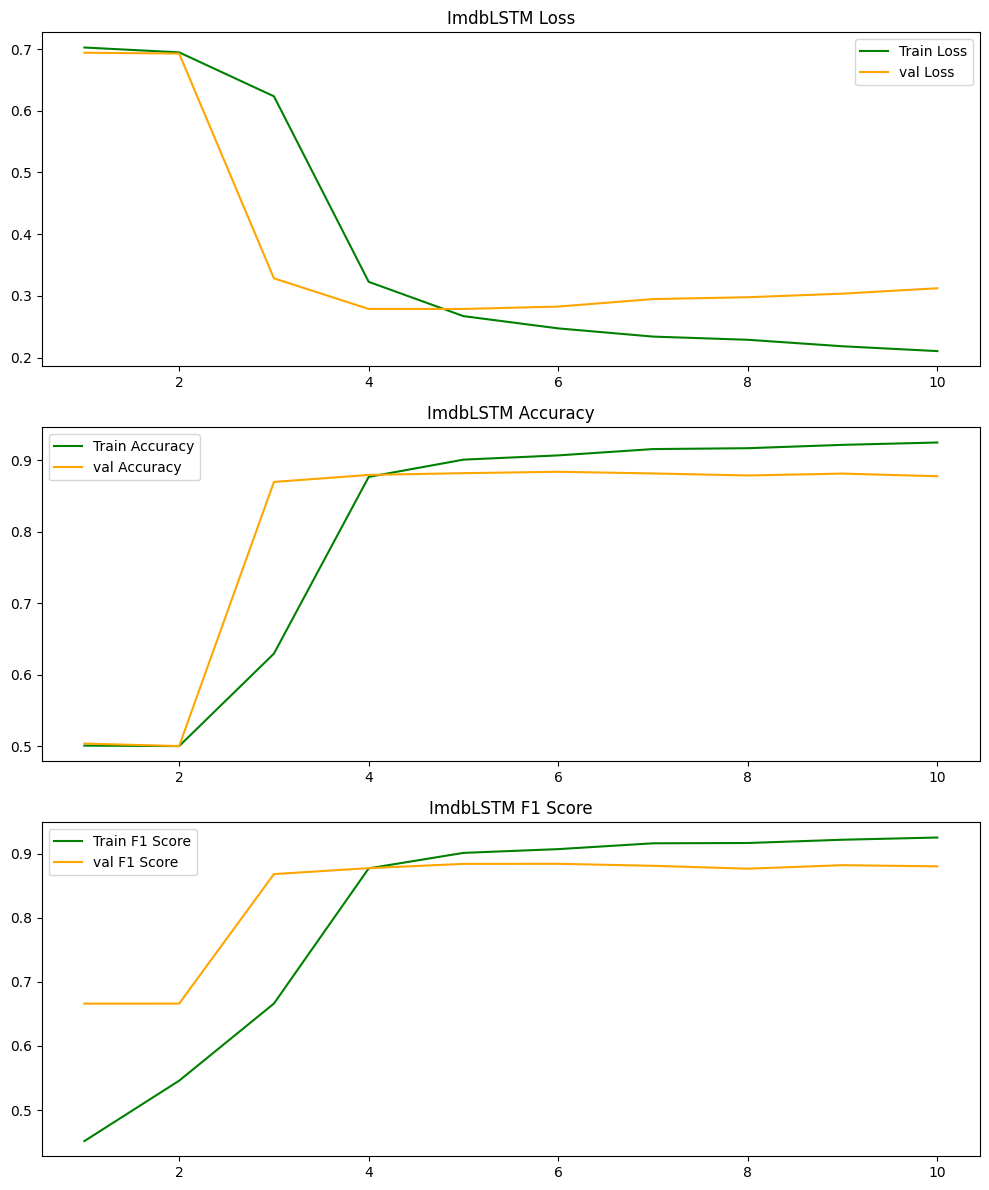

In [31]:
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


MODEL_NAME = "ImdbLSTM"
best_cum_val_acc = 0
best_weights = None
best_epoch = np.inf

results = {"train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": [],
            "train_f1": [],
            "val_f1": []
            }


for epoch in range(epochs):
    cum_train_loss, cum_train_acc, cum_train_f1 = 0, 0, 0
    model.train()

    for batch, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        y_logits = model(inputs).squeeze()

        train_loss = loss_function(y_logits, targets)

        optimizer.zero_grad()
        train_loss.backward()
        cum_train_loss += train_loss.item()
        optimizer.step()


        y_probs = y_logits.sigmoid()
        y_preds = (y_probs >= 0.5).float()

        cum_train_acc += accuracy_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())
        cum_train_f1 += f1_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())

    cum_train_loss /= len(train_dataloader)
    cum_train_acc /= len(train_dataloader)
    cum_train_f1 /= len(train_dataloader)

    # validation loop
    cum_val_loss, cum_val_acc, cum_val_f1 = 0, 0, 0
    model.eval()

    with torch.inference_mode():
        for batch, (inputs, targets) in enumerate(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            y_logits = model(inputs).squeeze()

            test_loss = loss_function(y_logits, targets)
            cum_val_loss += test_loss.item()

            y_probs = y_logits.sigmoid()
            y_preds = (y_probs >= 0.5).float()

            cum_val_acc += accuracy_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())
            cum_val_f1 += f1_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())

        cum_val_loss /= len(val_dataloader)
        cum_val_acc /= len(val_dataloader)
        cum_val_f1 /= len(val_dataloader)


    if cum_val_acc > best_cum_val_acc:
        best_cum_val_acc = cum_val_acc
        best_weights = copy.deepcopy(model.state_dict())
        best_epoch = epoch+1

    epoch_display = f" {epoch+1}" if epoch < 10 else epoch
    print(f"Epoch: {Fore.YELLOW}{epoch_display}{Style.RESET_ALL} | "
            f"Loss: ({Fore.YELLOW}{cum_train_loss:.4f}, {cum_val_loss:.4f}{Style.RESET_ALL}) | "
            f"Acc: ({Fore.YELLOW}{100*cum_train_acc:.4f}, {100*cum_val_acc:.4f}{Style.RESET_ALL})% | "
            f"F1: ({Fore.YELLOW}{100*cum_train_f1:.4f}, {100*cum_val_f1:.4f}{Style.RESET_ALL})% |")


    results["train_loss"].append(cum_train_loss)
    results["val_loss"].append(cum_val_loss)
    results["train_acc"].append(cum_train_acc)
    results["val_acc"].append(cum_val_acc)
    results["train_f1"].append(cum_train_f1)
    results["val_f1"].append(cum_val_f1)


### Saving Best Model weights
os.makedirs('checkpoints', exist_ok=True)
torch.save(best_weights, f"checkpoints/{MODEL_NAME}_checkpoint.pth.tar")
print(f'Model checkpoint saved at epoch {best_epoch}')

plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.plot(np.arange(1,epochs+1), results["train_loss"], label='Train Loss', color='green')
plt.plot(np.arange(1,epochs+1), results["val_loss"], label='val Loss', color='orange')
plt.title(f'{MODEL_NAME} Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.arange(1,epochs+1), results["train_acc"], label='Train Accuracy', color='green')
plt.plot(np.arange(1,epochs+1), results["val_acc"], label='val Accuracy', color='orange')
plt.title(f'{MODEL_NAME} Accuracy')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.arange(1,epochs+1), results["train_f1"], label='Train F1 Score', color='green')
plt.plot(np.arange(1,epochs+1), results["val_f1"], label='val F1 Score', color='orange')
plt.title(f'{MODEL_NAME} F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

/////////////////////////////////////////////////////////////////////////////////////////////////////////

# [10] *Gated Recurrent Unit* (GRU) Recurrent Neural Network

In [32]:
from torch import nn

class ImdbGRU(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_size = INPUT_SIZE
        self.gru_hidden_size = 130
        self.gru_layers = 3
        self.fc_size = [64, 32, 16]
        self.op_size = 1


        # GRU Layer
        # [BATCH_SIZE, max_features] --> ([BATCH_SIZE, gru_hidden_size], [gru_layers, gru_hidden_size])
        # [128, 5000] --> ([128, 130], (1, 130))
        self.gru = nn.GRU(input_size=self.input_size,
                           hidden_size=self.gru_hidden_size,
                           num_layers=self.gru_layers,
                           bias=True,
                           batch_first=True,
                           dropout=0.4,
                           bidirectional=False
                          )



        # Classifier Head
        # [BATCH_SIZE, gru_hidden_size] --> [BATCH_SIZE, op_size]
        # [128, 130] --> [129, 1]
        self.layer_stack = nn.Sequential(

            # [BATCH_SIZE, gru_hidden_size] --> [BATCH_SIZE, gru_hidden_size]
            # [128, 130] --> [128, 130]
            nn.LayerNorm(normalized_shape=self.gru_hidden_size),

            # [BATCH_SIZE, gru_hidden_size] --> [BATCH_SIZE, fc_size[0]]
            # [128, 130] --> [128, 64]
            nn.Linear(in_features=self.gru_hidden_size, out_features=self.fc_size[0], bias=True),
            nn.BatchNorm1d(self.fc_size[0]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[0]] --> [BATCH_SIZE, fc_size[1]]
            # [128, 64] --> [128, 32]
            nn.Linear(in_features=self.fc_size[0], out_features=self.fc_size[1], bias=True),
            nn.BatchNorm1d(self.fc_size[1]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[1]] --> [BATCH_SIZE, fc_size[2]]
            # [128, 32] --> [128, 16]
            nn.Linear(in_features=self.fc_size[1], out_features=self.fc_size[2], bias=True),
            nn.BatchNorm1d(self.fc_size[2]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[2]] --> [BATCH_SIZE, op_size]
            # [128, 16] --> [128, 1]
            nn.Linear(in_features=self.fc_size[2], out_features=self.op_size, bias=True)
        )

        self.fc = nn.Linear(in_features=self.gru_hidden_size, out_features=self.op_size, bias=True)


    def forward(self, x):
        gru_op, _ = self.gru(x)
        return self.layer_stack(gru_op)
        # return self.fc(gru_op)

# [11] Training *GRU*

In [33]:
epochs = 10
loss_function = torch.nn.BCEWithLogitsLoss().to(device)
model = ImdbGRU().to(device)
# model = torch.nn.DataParallel(model, device_ids=[0, 1]).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.001)

Epoch:  1 | Loss: (0.6997, 0.6927) | Acc: (50.2804, 50.1758)% | F1: (43.6978, 63.4856)% |
Epoch:  2 | Loss: (0.6937, 0.6720) | Acc: (50.9365, 62.1289)% | F1: (47.5409, 70.3798)% |
Epoch:  3 | Loss: (0.4175, 0.2797) | Acc: (83.5912, 88.6328)% | F1: (83.5577, 88.6019)% |
Epoch:  4 | Loss: (0.2809, 0.2758) | Acc: (89.5508, 88.6328)% | F1: (89.4572, 88.6369)% |
Epoch:  5 | Loss: (0.2541, 0.2866) | Acc: (90.6250, 88.4082)% | F1: (90.5543, 88.1299)% |
Epoch:  6 | Loss: (0.2445, 0.2883) | Acc: (91.0832, 88.3789)% | F1: (91.0196, 88.2650)% |
Epoch:  7 | Loss: (0.2384, 0.2906) | Acc: (91.3011, 88.4375)% | F1: (91.2316, 88.3185)% |
Epoch:  8 | Loss: (0.2318, 0.3014) | Acc: (91.7443, 87.8418)% | F1: (91.6552, 87.4769)% |
Epoch:  9 | Loss: (0.2269, 0.3062) | Acc: (91.7142, 87.6660)% | F1: (91.6282, 87.3208)% |
Epoch:  10 | Loss: (0.2210, 0.3136) | Acc: (91.8970, 87.8613)% | F1: (91.8431, 87.9895)% |
Model checkpoint saved at epoch 3


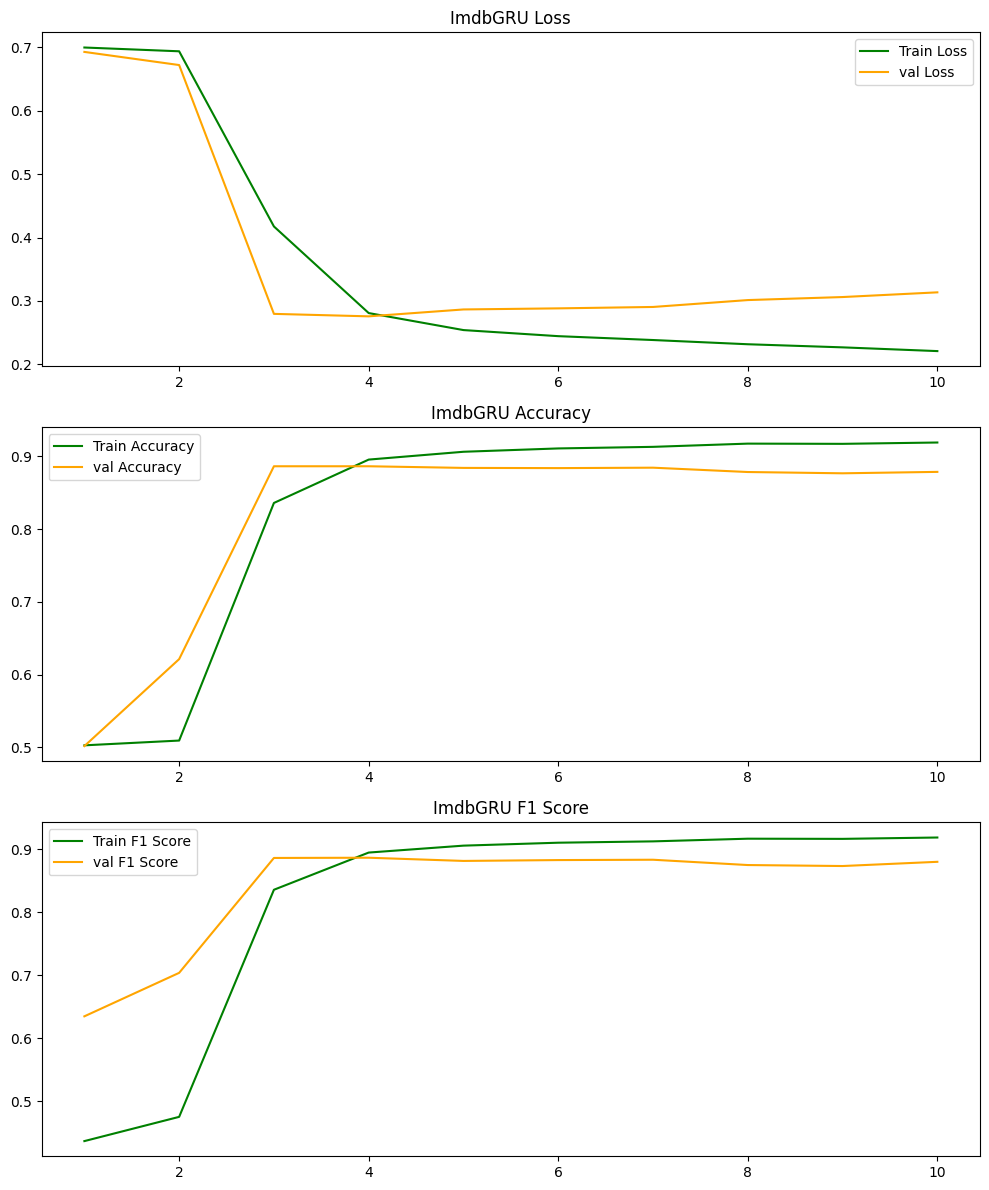

In [34]:
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


MODEL_NAME = "ImdbGRU"
best_cum_val_acc = 0
best_weights = None
best_epoch = np.inf

results = {"train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": [],
            "train_f1": [],
            "val_f1": []
            }


for epoch in range(epochs):
    cum_train_loss, cum_train_acc, cum_train_f1 = 0, 0, 0
    model.train()

    for batch, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        y_logits = model(inputs).squeeze()

        train_loss = loss_function(y_logits, targets)

        optimizer.zero_grad()
        train_loss.backward()
        cum_train_loss += train_loss.item()
        optimizer.step()


        y_probs = y_logits.sigmoid()
        y_preds = (y_probs >= 0.5).float()

        cum_train_acc += accuracy_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())
        cum_train_f1 += f1_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())

    cum_train_loss /= len(train_dataloader)
    cum_train_acc /= len(train_dataloader)
    cum_train_f1 /= len(train_dataloader)

    # validation loop
    cum_val_loss, cum_val_acc, cum_val_f1 = 0, 0, 0
    model.eval()

    with torch.inference_mode():
        for batch, (inputs, targets) in enumerate(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            y_logits = model(inputs).squeeze()

            test_loss = loss_function(y_logits, targets)
            cum_val_loss += test_loss.item()

            y_probs = y_logits.sigmoid()
            y_preds = (y_probs >= 0.5).float()

            cum_val_acc += accuracy_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())
            cum_val_f1 += f1_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())

        cum_val_loss /= len(val_dataloader)
        cum_val_acc /= len(val_dataloader)
        cum_val_f1 /= len(val_dataloader)


    if cum_val_acc > best_cum_val_acc:
        best_cum_val_acc = cum_val_acc
        best_weights = copy.deepcopy(model.state_dict())
        best_epoch = epoch+1

    epoch_display = f" {epoch+1}" if epoch < 10 else epoch
    print(f"Epoch: {Fore.YELLOW}{epoch_display}{Style.RESET_ALL} | "
            f"Loss: ({Fore.YELLOW}{cum_train_loss:.4f}, {cum_val_loss:.4f}{Style.RESET_ALL}) | "
            f"Acc: ({Fore.YELLOW}{100*cum_train_acc:.4f}, {100*cum_val_acc:.4f}{Style.RESET_ALL})% | "
            f"F1: ({Fore.YELLOW}{100*cum_train_f1:.4f}, {100*cum_val_f1:.4f}{Style.RESET_ALL})% |")


    results["train_loss"].append(cum_train_loss)
    results["val_loss"].append(cum_val_loss)
    results["train_acc"].append(cum_train_acc)
    results["val_acc"].append(cum_val_acc)
    results["train_f1"].append(cum_train_f1)
    results["val_f1"].append(cum_val_f1)


### Saving Best Model weights
os.makedirs('checkpoints', exist_ok=True)
torch.save(best_weights, f"checkpoints/{MODEL_NAME}_checkpoint.pth.tar")
print(f'Model checkpoint saved at epoch {best_epoch}')

plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.plot(np.arange(1,epochs+1), results["train_loss"], label='Train Loss', color='green')
plt.plot(np.arange(1,epochs+1), results["val_loss"], label='val Loss', color='orange')
plt.title(f'{MODEL_NAME} Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.arange(1,epochs+1), results["train_acc"], label='Train Accuracy', color='green')
plt.plot(np.arange(1,epochs+1), results["val_acc"], label='val Accuracy', color='orange')
plt.title(f'{MODEL_NAME} Accuracy')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.arange(1,epochs+1), results["train_f1"], label='Train F1 Score', color='green')
plt.plot(np.arange(1,epochs+1), results["val_f1"], label='val F1 Score', color='orange')
plt.title(f'{MODEL_NAME} F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

///////////////////////////////////////////////////////////////////////////////////////////////////////

# [12] Predicting Sentiment of Random Movie Review

In [35]:
MODEL_NAME = "ImdbGRU"
model = ImdbGRU().to(device)
model.load_state_dict(torch.load(f"checkpoints/{MODEL_NAME}_checkpoint.pth.tar", weights_only=True))

<All keys matched successfully>

In [36]:
vectorizer = joblib.load("checkpoints/vectorizer.joblib")
vectorizer

TfidfVectorizer(max_features=5000)

In [37]:
def predict_sentiment(model, vectorizer, sentence):

    inputs = [data_preprocessing(sentence)]
    inputs = vectorizer.transform(inputs)
    inputs = torch.tensor(inputs.toarray(), dtype=torch.float32).to(device)

    model.eval()
    with torch.inference_mode():
        inputs_logits = model(inputs).squeeze()
        inputs_probs = inputs_logits.sigmoid()
        inputs_preds = (inputs_probs >= 0.5).float()

    if inputs_preds == 1.0:
        sentiment = "Positive"
    else:
        sentiment = "Negitive"

    return sentiment

In [38]:
sentences = [
    "This movie is really good",
    "You should watch this movie only if you nothing else to do.",
    "I've had mosquito bites that were more passionate than this undead, unrequited, and altogether unfun pseudo-romantic riff on Romeo and Juliet",
    "An outstanding and brilliantly made movie after a long time. Usually, I do not encourage bollywood movies but this movie has a storyline that needs your patience and a full on theatrical retreat. ",
    "Movie is an average entertainer.. first half is boring..  jumping from one scene from another .. Content and timing of dialogues are utter nonsense,  seems to be written by inexperienced person .. Ranbir kapoor is good , tried his best with poor dialogues ... alia - Ranbir love story is over emphasized , forceful introduction of alia in few scenes when it was not required .. and body movements of Ranbir during visions was totally hilarious ..Second half was better ... but use of words like button , bhasad seems imbecile with movie titles like brahmastra .. and doing ending like bahubali lacks originality .. Vfx were good ..Bolloywood needs some originality , brains and better script writing and mature content .. Brahmastra is just one time watch .. only if you have time and longing for a time pass movie..",
    "I never thought that this movie would be good, but it turned out to be great",
    "While I had the misfortune to see 'Bright' in a theater, most people will simply press 'play' out of curiosity on their TV remote. I am willing to concede that this might elevate the experience a little ... the ability to take a quick trip to the kitchen or restroom after shouting 'no, don't pause it' to your partner on the couch will be liberating."
    ]

for sentence in sentences:
    print(sentence)
    print(predict_sentiment(model, vectorizer, sentence))
    print()

This movie is really good
Positive

You should watch this movie only if you nothing else to do.
Negitive

I've had mosquito bites that were more passionate than this undead, unrequited, and altogether unfun pseudo-romantic riff on Romeo and Juliet
Positive

An outstanding and brilliantly made movie after a long time. Usually, I do not encourage bollywood movies but this movie has a storyline that needs your patience and a full on theatrical retreat. 
Positive

Movie is an average entertainer.. first half is boring..  jumping from one scene from another .. Content and timing of dialogues are utter nonsense,  seems to be written by inexperienced person .. Ranbir kapoor is good , tried his best with poor dialogues ... alia - Ranbir love story is over emphasized , forceful introduction of alia in few scenes when it was not required .. and body movements of Ranbir during visions was totally hilarious ..Second half was better ... but use of words like button , bhasad seems imbecile with movi

In [39]:
import shutil
from google.colab import files


# List of directories and files to copy
os.makedirs('temp_download', exist_ok=True)
items_to_include = ['aclImdb', 'checkpoints', 'df_preprocessed_review.parquet']

# Copy each item to the temporary directory
for item in items_to_include:
    if os.path.exists(item):
        if os.path.isdir(item):
            shutil.copytree(item, os.path.join('temp_download', item))
        else:
            shutil.copy2(item, 'temp_download')

# Compress the temporary directory
shutil.make_archive('downloadable_files', 'zip', 'temp_download')

# Remove the temporary directory
shutil.rmtree('temp_download')

# Download the ZIP file
files.download('downloadable_files.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>